<a href="https://colab.research.google.com/github/Sreemourya710/Assignment2/blob/main/Assgnmt2_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium==0.27.1 -q
!pip install gymnasium[box2d] -q
!pip install moviepy -q
!pip install -U kora -q

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
%cd gdrive/MyDrive/HW2DQN/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/HW2DQN


In [ ]:
import random
import numpy as np
import torch.cuda


def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


# Util function to apply reward-discounting scheme on a list of instant-reward (from eq 8 of HW1)
def apply_discount(raw_reward, gamma=0.99):
    # TODO(DONE): Compute discounted_rtg_reward (as a list) from raw_reward
    # HINT: Reverse the input list, keep a running-average. Reverse again to get the correct order.
    discounted_rtg_reward = []
    discounted_reward = 0
    for r in reversed(raw_reward):
        # print(type(r), r)
        discounted_reward = r + discounted_reward * gamma
        discounted_rtg_reward.append(discounted_reward)
    discounted_rtg_reward = list(reversed(discounted_rtg_reward))

    # Normalization
    # print(type(discounted_rtg_reward))
    discounted_rtg_reward = np.array(discounted_rtg_reward)

    discounted_rtg_reward = discounted_rtg_reward - np.mean(discounted_rtg_reward) / (np.std(discounted_rtg_reward) + np.finfo(np.float32).eps)
    return torch.tensor(discounted_rtg_reward, dtype=torch.float32, device=get_device())

In [ ]:
import copy
import pickle
import random
import gymnasium as gym
import torch
from collections import deque, namedtuple
from gymnasium.utils.save_video import save_video
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical
class DQNTrainer:
    def __init__(self, params):
        self.params = params
        self.env = gym.make(self.params['env_name'])
        self.q_net = QNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.target_net = QNet(input_size=self.env.observation_space.shape[0], output_size=self.env.action_space.n, hidden_dim=self.params['hidden_dim']).to(get_device())
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.epsilon = self.params['init_epsilon']
        self.optimizer = Adam(params=self.q_net.parameters(), lr=self.params['lr'])
        self.replay_memory = ReplayMemory(capacity=self.params['rm_cap'])

    def run_training_loop(self):
        list_ep_reward = list()
        obs, _ = self.env.reset(seed=self.params['rng_seed'])
        for idx_episode in range(self.params['n_episode']):
            ep_len = 0
            while True:
                ep_len += 1
                action = self.get_action(obs)
                next_obs, reward, terminated, truncated, info = self.env.step(action)
                if terminated or truncated:
                    self.epsilon = max(self.epsilon*self.params['epsilon_decay'], self.params['min_epsilon'])
                    next_obs = None
                    self.replay_memory.push(obs, action, reward, next_obs, not (terminated or truncated))
                    list_ep_reward.append(ep_len)
                    print(f'End of episode {idx_episode} with epsilon = {self.epsilon: 0.2f} and reward = {ep_len}, memory = {len(self.replay_memory.buffer)}')
                    obs, _ = self.env.reset()
                    break
                self.replay_memory.push(obs, action, reward, next_obs, not (terminated or truncated))
                obs = copy.deepcopy(next_obs)
                self.update_q_net()
                self.update_target_net()
        # Save avg-rewards as pickle files
        pkl_file_name = self.params['exp_name'] + '.pkl'
        with open(pkl_file_name, 'wb') as f:
            pickle.dump(list_ep_reward, f)
        # Save a video of the trained agent playing
        self.generate_video()
        # Close environment
        self.env.close()

    def get_action(self, obs):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                obs_tensor = torch.from_numpy(obs).float().unsqueeze(0).to(get_device())
                q_values = self.q_net(obs_tensor)
                action = torch.argmax(q_values).item()
                return action
    def update_q_net(self):
        if len(self.replay_memory.buffer) < self.params['batch_size']:
            return
        batch = self.replay_memory.sample(self.params['batch_size'])

        state = []
        action = []
        reward = []
        next_state = []
        done = []

        for i in batch:
            state.append(i[0])
            action.append(i[1])
            reward.append(i[2])
            if len(next_state) == 0:
                next_state.append(state[-1])
            else:
                next_state.append(next_state[-1] if i[3] is None else i[3])
            done.append(int(i[4]))

        state = torch.from_numpy(np.array(state)).to(get_device())
        action = torch.tensor(action).to(get_device())
        reward = torch.tensor(reward).to(get_device())
        next_state = torch.from_numpy(np.array(next_state)).to(get_device())
        done = torch.tensor(done).to(get_device())

        # Use the Q-network to predict the state values for the current state of each sample in the batch
        predicted_state_value = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)

        # Use the target network to predict the target state values for the next state of each sample in the batch
        target_state_value = self.target_net(next_state)
        target_value = reward + self.params['gamma'] * torch.max(target_state_value, dim=1)[0] * (1 - done)

        criterion = nn.SmoothL1Loss()
        q_loss = criterion(predicted_state_value, target_value.unsqueeze(1))
        self.optimizer.zero_grad()
        q_loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        if len(self.replay_memory.buffer) < self.params['batch_size']:
            return
        q_net_state_dict = self.q_net.state_dict()
        target_net_state_dict = self.target_net.state_dict()
        for key in q_net_state_dict:
            target_net_state_dict[key] = self.params['tau']*q_net_state_dict[key] + (1 - self.params['tau'])*target_net_state_dict[key]
        self.target_net.load_state_dict(target_net_state_dict)

    def generate_video(self, max_frame=1000):
        self.env = gym.make(self.params['env_name'], render_mode='rgb_array_list')
        self.epsilon = 0.0
        obs, _ = self.env.reset()
        for _ in range(max_frame):
            action = self.get_action(obs)
            obs, reward, terminated, truncated, info = self.env.step(action)
            if terminated or truncated:
                break
        save_video(frames=self.env.render(), video_folder=self.params['env_name'][:-3], fps=self.env.metadata['render_fps'], step_starting_index=0, episode_index=0)


class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(args)

    def sample(self, n_samples):
        n = min(n_samples, len(self.buffer))
        return random.sample(self.buffer, n)


class QNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(QNet, self).__init__()
        self.ff_net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.ff_net(obs)

In [ ]:
# set simulation parameters
params = {
    'env_name': 'CartPole-v1',
    'rng_seed': 6369,
    'n_episode': 35,
    'rm_cap': 8192,
    'batch_size': 128,
    'hidden_dim': 128,
    'init_epsilon': 0.9,
    'min_epsilon': 0.05,
    'epsilon_decay': 0.99,
    'gamma': 0.99,
    'tau': 0.005,
    'lr': 3e-3,
    'exp_name': 'CartPole_v1_t0'
}

# Seed RNGs
seed_everything(params['rng_seed'])

# Train agent
trainer = DQNTrainer(params)
trainer.run_training_loop()

End of episode 0 with epsilon =  0.89 and reward = 15, memory = 15
End of episode 1 with epsilon =  0.88 and reward = 10, memory = 25
End of episode 2 with epsilon =  0.87 and reward = 18, memory = 43
End of episode 3 with epsilon =  0.86 and reward = 16, memory = 59
End of episode 4 with epsilon =  0.86 and reward = 17, memory = 76
End of episode 5 with epsilon =  0.85 and reward = 23, memory = 99
End of episode 6 with epsilon =  0.84 and reward = 10, memory = 109
End of episode 7 with epsilon =  0.83 and reward = 14, memory = 123
End of episode 8 with epsilon =  0.82 and reward = 37, memory = 160


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:928: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


End of episode 9 with epsilon =  0.81 and reward = 43, memory = 203
End of episode 10 with epsilon =  0.81 and reward = 10, memory = 213
End of episode 11 with epsilon =  0.80 and reward = 12, memory = 225
End of episode 12 with epsilon =  0.79 and reward = 25, memory = 250
End of episode 13 with epsilon =  0.78 and reward = 19, memory = 269
End of episode 14 with epsilon =  0.77 and reward = 10, memory = 279
End of episode 15 with epsilon =  0.77 and reward = 23, memory = 302
End of episode 16 with epsilon =  0.76 and reward = 15, memory = 317
End of episode 17 with epsilon =  0.75 and reward = 9, memory = 326
End of episode 18 with epsilon =  0.74 and reward = 18, memory = 344
End of episode 19 with epsilon =  0.74 and reward = 13, memory = 357
End of episode 20 with epsilon =  0.73 and reward = 11, memory = 368
End of episode 21 with epsilon =  0.72 and reward = 10, memory = 378
End of episode 22 with epsilon =  0.71 and reward = 11, memory = 389
End of episode 23 with epsilon =  0.

Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/HW2DQN/CartPole/rl-video-episode-0.mp4


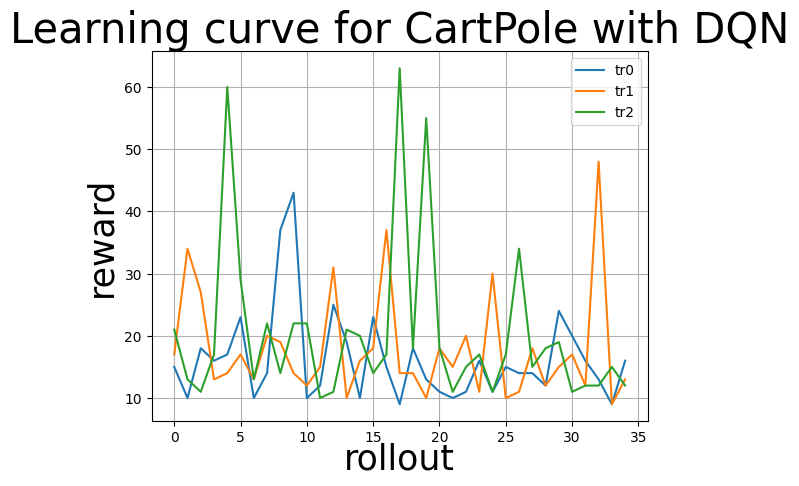

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
file_name0 = 'CartPole_v1_t0' + '.pkl'
file_name1 = 'CartPole_v1_t1' + '.pkl'
file_name2 = 'CartPole_v1_t2' + '.pkl'

with open(file_name0, 'rb') as f:
    ro_reward0 = pickle.load(f)

with open(file_name1, 'rb') as f:
    ro_reward1 = pickle.load(f)

with open(file_name2, 'rb') as f:
    ro_reward2 = pickle.load(f)

# Plot the data
sns.lineplot(data=ro_reward0, linestyle='-', label='tr0')
sns.lineplot(data=ro_reward1, linestyle='-', label='tr1')
sns.lineplot(data=ro_reward2, linestyle='-', label='tr2')
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for CartPole with DQN', fontsize=30)
plt.legend()
plt.grid()
plt.show()

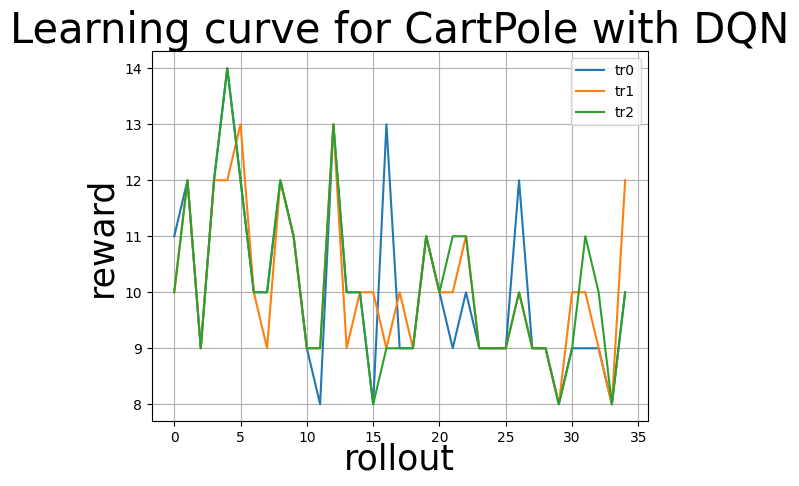

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
file_name0 = 'CartPole_v1_t0' + '.pkl'
file_name1 = 'CartPole_v1_t1' + '.pkl'
file_name2 = 'CartPole_v1_t2' + '.pkl'

with open(file_name0, 'rb') as f:
    ro_reward0 = pickle.load(f)

with open(file_name1, 'rb') as f:
    ro_reward1 = pickle.load(f)

with open(file_name2, 'rb') as f:
    ro_reward2 = pickle.load(f)

# Plot the data
sns.lineplot(data=ro_reward0, linestyle='-', label='tr0')
sns.lineplot(data=ro_reward1, linestyle='-', label='tr1')
sns.lineplot(data=ro_reward2, linestyle='-', label='tr2')
plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for CartPole with DQN', fontsize=30)
plt.legend()
plt.grid()
plt.show()

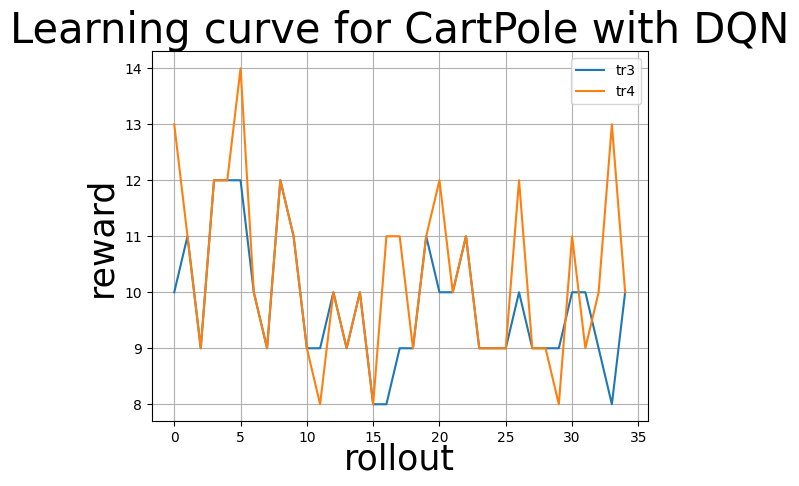

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
file_name0 = 'CartPole_v1_t3' + '.pkl'
file_name1 = 'CartPole_v1_t4' + '.pkl'


with open(file_name0, 'rb') as f:
    ro_reward0 = pickle.load(f)

with open(file_name1, 'rb') as f:
    ro_reward1 = pickle.load(f)

with open(file_name2, 'rb') as f:
    ro_reward2 = pickle.load(f)

# Plot the data
sns.lineplot(data=ro_reward0, linestyle='-', label='tr3')
sns.lineplot(data=ro_reward1, linestyle='-', label='tr4')

plt.xlabel('rollout', fontsize=25, labelpad=-2)
plt.ylabel('reward', fontsize=25)
plt.title('Learning curve for CartPole with DQN', fontsize=30)
plt.legend()
plt.grid()
plt.show()

SreeMourya Ravirala
1002029130